# Jeu du serpent - *Snake*

Dans ce chapitre, nous allons mettre à profit la plupart des techniques que nous avons apprises jusqu'ici afin de construire une implémentation réaliste du jeu bien connu du [serpent](https://fr.wikipedia.org/wiki/Snake_(genre_de_jeu_vid%C3%A9o)) (*Snake game* [en](https://en.wikipedia.org/wiki/Snake_(video_game_genre))).

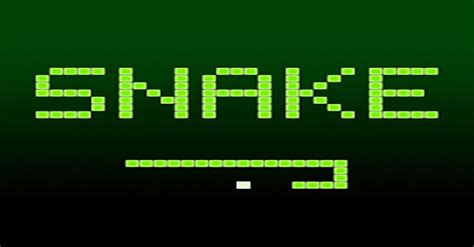

Comme nous allons développer une application plus substantielle cette fois, de manière incrémentale, vous trouverez certainement plus commode d'utiliser un éditeur de texte (aussi simple que Notepad ou aussi sophistiqué qu'un IDE). À chaque étape, écrivez votre code dans l'éditeur et sauvegarder la nouvelle version dans un fichier texte - utiliser alors le bouton Load de l'ARMlite pour charger la dernière version du code.

## Un serpent qui bouge

Nous allons commencer par écrire un simple boucle qui va déplacer la tête du serpent d'un pixel vers la droite à chaque itération. Dans cette version, le serpent va grandir continuellement, ce qui n'est pas ce que nous voulons pour le jeu final, mais nous améliorerons ce point un peu plus tard:

```
// Définir les registres
    // R0-R2: réservés pour des usages temporaires
    // Variables globales
    // R3: position de la queue
    // R4: poistion de la tête
    // Constantes:
    MOV R10, #.PixelScreen
    MOV R11, #.green // couleur du serpent
    
// Initialiser le jeu
    MOV R3, #1084 // pour la queue et ...
    MOV R4, #1088 // pour la tête à côté (4 octets = 1 mot = 1 pixel)
    STR R11, [R10+R3]
    STR R11, [R10+R4]

// rafraîchissement ou mise à jour (update):
maj:
    ADD R4, R4, #4    // incrémenter la position de la tête
    STR R11, [R10+R4] //dessiner la nouvelle tête
    B maj
```

#### Exercice 39

Charger le code et faites le fonctionner en mode pas à pas pendant quelques itérations de façon à bien comprendre ce qu'il fait.

Ensuite faite-le tourner normalement. Quel problèmes observe-t-on immédiatement?

**Sauvegarder votre programme**
___

## Controler la fréquence de rafraîchissement

Parmi les problèmes trouvés à la première étape, le plus immédiat est la vitesse. La meilleur façon de la controler est d'utiliser les interruptions de l'horloge. Effectuer les modifications suivantes au code:

```
// Définir les registres
    ...

// Configurer les interruptions mais sans les activer pour l'instant
    MOV R0, #maj
    STR R0, .ClockISR
    MOV R0, #50
    STR R0, .ClockInterruptFrequency

// Initialiser le jeu
    ...
    // ici, nous sommes prêt à gérer les interruptions
    MOV R0, #1
    STR R0, .InterruptRegister

mainLoop: b mainLoop // pour occuper le processeur en attente d'interruption

// rafraîchissement ou mise à jour (update)
// piloté par l'horloge
maj:
    ADD R4, R4, #4    // incrémenter la position de la tête
    STR R11, [R10+R4] // dessiner la nouvelle tête
    RFE
```

*Notes*:
- Nous configurons les interruptions d'horloge au début (par convention), mais les interruptions ne sont pas activées tant que le jeu n'a pas été initialisé - autrement la routine maj pourrait être appelée avant même qu'il n'y ait un serpent à déplacer.
- **ClockInterruptFrequency** est défini en millisecondes. Ici, nous l'avons configuré pour qu'une interruption horloge ait lieu toutes les 50 millisecondes.
- Comme **maj** est déclenchée par la survenue d'une interruption, elle se termine par `RFE` à la place de `B maj`.
- **maj** ne sauvegarde aucun registre sur la pile car le seul registre qu'elle modifie est R4 qui est une variable globale (partagée par tout le code).

#### Exercice 40

Effectuer les changements indiqués et faites tourner le programme.

Modifier **ClockInterruptFrequency** en augmentant ou en diminuant sa valeur (par rapport à 50 millisecondes)

Comment pourrions-nous faire pour permettre à l'utilisateur de modifier la vitesse ce qui correspondrait à différents niveaux de difficulté? Seule une description est attendue, pas la peine de la coder pour l'instant.

**Sauvegarder votre programme**
___

## Changer la direction avec les touches H, J, K, L

Ensuite, nous allons permettre à l'utilisateur de modifier la direction du serpent en utilisant les touches H (gauche), J (bas), K (haut), L (droite). Nous pourrions vérifier si des touches ont été utilisées dans la boucle principale, mais une solution plus élégante est d'utiliser les interruptions clavier. Voici cette routine d'interruption:

```
// routine d'interruption clavier
// Si la touche est valide (H,J,K,L), la transférer dans R7
clavier: PUSH {R0}
    LDR R0, .LastKey //lire la dernière touche enfoncée (mais sans attendre ...)
    CMP R0, #74 // touche J (haut)
    BEQ majTouche
    CMP R0, #75 // touche K (bas)
    BEQ majTouche
    CMP R0, #72 // touche H (gauche)
    BEQ majTouche
    CMP R0, #76 // touche L (droite)
    BEQ majTouche
    B .+2 // branchement inconditionnel deux instructions plus bas (POP...)
majTouche: MOV R7, R0
    POP {R0}
    RFE
```

*Notes*:
- Cette nouvelle routine peut être placée après la routine **maj**.
- `B .+2` signifie «effectuer un branchement deux instructions plus loin» (i.e. sauter par dessus la prochaîne instruction). Lorsqu'on effectue des petits sauts localement, cette syntaxe évite l'encombrement d'avoir à définir une nouvelle étiquette.
- Ici, nous sauvegardons le registre R0 sur la pile car il peut être utilisé à d'autres fins lorsque la routine est appelée. En revanche, R7 a une portée globale.

Et voici les modifications nécessaires à apporter en début de programme - l'une pour la définition d'une nouvelle variable globale, l'autre pour la configuration d'une interruption supplémentaire:

```
// Définir les registres
    ...
    // R7: valeur ASCII de la dernière touche enfoncée
    ...
//initialiser le jeu
    ...
    MOV R7, #76 //Au départ le serpent se déplace vers la droite
    // ici, nous sommes prêt à gérer les interruptions
    ...

// Configurer les interruptions mais sans les activer pour l'instant
    ...
    MOV R0, #clavier
    STR R0, .KeyboardISR
    MOV R0, #1
    STR R0, .KeyboardMask

...
```

À présent, nous devons exploiter la dernière touche utilisée (dans R7) afin de contrôler la direction du mouvement dans la routine **maj**:

```
// rafraîchissement ou mise à jour (update):
maj:
    CMP R7, #74
    BEQ bas
    CMP R7, #75
    BEQ haut
    CMP R7, #72
    BEQ gauche
    CMP R7, #76
    BEQ droite
gauche: SUB R4, R4, #4
    B repeindre
droite: ADD R4, R4, #4
    B repeindre
haut: SUB R4, R4, #256 // -64*4=-256 -> monter d'une ligne
    B repeindre
bas: ADD R4, R4, #256  // +64*4=256 -> descendre d'une ligne
repeindre:
    STR R11, [R10+R4]
    RFE
```

#### Exercice 41

Ajouter ces portions de code à l'ancien (à la bonne place) puis faites tourner le programme. Vérifiez que tout fonctionne bien en déplaçant le serpent dans les quatre directions (si c'est difficile allonger la durée entre deux interruptions horloge) puis faites une capture d'écran montrant la zone d'affichage.

Pourquoi le fait de sortir de l'écran par le haut ou par le bas produit une erreur alors que ce n'est pas le cas lorsqu'on sort par la gauche ou par la droite?

**Sauvegarder votre programme**
____

## Heurter un côté fait perdre

Dans le vrai jeu, si le serpent heurte l'un des quatre bords de la scène, on perd. Les bords haut et bas de la scène sont simples à traiter: nous pouvons tester si la valeur de R4 est inférieure à 0 ou supérieure à l'adresse du dernier pixel: 12284 (=64\*48\*4 - le 4 car un pixel fait 4 octets). Pour les bords gauche et droit, il va nous falloir regarder les 8 bits de poids faibles de l'index du pixel en utilisant un ET logique avec #255 (0x000000ff).
- Si le serpent bouge vers la gauche, nous devons agir au moment où ces 8 bits de poids faibles prennent la valeur 0,
- Si le serpent bouge vers la droite, nous devons agir au moment où ces 8 bits de poids faibles prennent la valeur #252 (car nous enlevons 4 à chaque fois, non 1).

Voici les modifications à appliquer au coeur de la routine de mise à jour:

```
...
gauche: AND R0, R4, #255
    CMP R0, #0
    BEQ perdu
    SUB R4, R4, #4
    B repeindre
droite: AND R0, R4, #255
    CMP R0, #252
    BEQ perdu
    ADD R4, R4, #4
    B repeindre
haut: SUB R4, R4, #256 // -64*4=-256 -> monter d'une ligne
    CMP R4, #0
    BLT perdu
    B repeindre
bas: ADD R4, R4, #256 // +64*4=256 -> descendre d'une ligne
    MOV R0, #12284
    CMP R4, R0
    BGT perdu
...    
```

Nous devons aussi définir l'étiquette **perdu** qu'on peut mettre à la toute fin du code:

```
...
perdu: 
    MOV R0, #msgPerdu
    STR R0, .WriteString
    HALT

msgPerdu: .ASCIZ " Game Over!\n"
```

#### Exercice 42

Modifier le code en incorporant ces changements et faites tourner le programmes quatre fois de façon à vous assurer que le jeu s'arrête correctement lorsqu'on touche un des quatres bords, mais que vous pouvez tout de même tourner juste avant.

(En programmation on parle de (test des) *conditions aux limites* \[ *edge* ou *boundary conditions* \] - dans ce cas, les conditions correspondent à une limite «physique»!)

Faites une copie d'écran montrant un virage juste avant la collision.

**Sauvegarder votre programme**
_____

## Le serpent ne peut pas se traverser lui même!

Nous pouvons aussi ajouter la règle que le jeu est perdu si la tête du serpent repasse sur son corps. La manière la plus simple de faire cela est de vérifier si le tête s'apprête à bouger sur un pixel qui est déjà vert.

```
...
repeindre:
    // commencer par vérifier que le serpent ne repasse pas sur lui-même
    LDR R0, [R10+R4] // lire sur l'écran le contenu du pixel où l'on s'apprête à mettre la tête
    CMP R0, R11      // ce pixel est-il vert ..
    BEQ perdu        // si oui, c'est perdu
    STR R11, [R10+R4]
    RFE
```

#### Exercice 43

Effectuer ce changement au code et faites tourner le programme. Prendre une capture d'écran qui montre que le jeu se termine si le serpent se traverse.

Que se passe-t-il si l'on inverse la direction du mouvement? (on va vers la gauche puis vers la droite par exemple)

**Sauvegarder votre programme**
___________

## Créer une pomme à une position aléatoire

À présent ajoutons une pomme, dans un position aléatoire à l'écran. Alors, à chaque fois que le serpent «mange» (passe sur) la pomme, nous ajouterons 1 au score du joueur et générerons une pomme à une nouvelle position aléatoire. Nous avons besoin de produire un nombre aléatoire dans l'intervalle 0-12280, et il doit être divisible par 4. Par défaut, la directive `.Random` de l'ARMlite produit un nombre aléatoire de 32-bits (un mot). Nous pouvons le combiner avec `AND` et le *masque de bits* `0b00000000'00000011'11111111'11111100` (soit 0x3ffc) pour le ramener à un nombre divisible par 4 (car les 2 bits de poids faibles sont à zéro) de l'intervalle 0-16380 ( car $3\cdot 16^3+15\cdot 16^2+15\cdot 16+12=16380$ ). Ensuite, il nous suffira de tester si le résultat est dans l'intervalle 0-12280 sinon nous relancerons «le dé» à nouveau.

Premièrement, nous définirons une nouvelle constante pour la couleur de la pomme, ainsi qu'une nouvelle variable globale pour tenir le compte du nombre de pommes mangés:

```
// Définir les registres
    ...
    // R8: Nombre de pommes mangées
    // Constantes:
    ...
    MOV R12, #.red // couleur d'une pomme
...
//initialiser le jeu
    MOV R8, #0
    ...
```

La sous-routine qui suit génére l'index d'un pixel au hasard dans l'intervalle requis et peint la pomme sur ce pixel. Elle vérifie aussi que nous ne plaçons pas la pomme sur le corps du serpent, c'est-à-dire sur un pixel déjà peint en vert:

```
// Produit une pomme dans une position au hasard mais valide
creerPomme: PUSH {R0, R1, LR}
auHasard: 
    LDR R1, .Random   // obtenir un mot de 32-bits au hasard
    MOV R0, #0x3ffc       
    AND R1, R1, R0    // conserver les bits de positions 2-14
    MOV R0, #12284
    CMP R1, R0
    BGT auHasard      // relancer si on est pas dans l'intervalle correct
    LDR R0, [R10+R1]
    CMP R0, R11
    BEQ auHasard      // relancer si on tombe sur le corps du serpent
    STR R12, [R10+R1] // dessiner la pomme
    POP {R0, R1, LR}
    RET
```

*Notes*:
- Cette nouvelle routine peut être placée à n'importe quel endroit pourvu qu'elle ne se chevauche pas avec une routine existante. L'auteur la place juste avant **perdu** et vous suggère d'en faire autant pour rester consistent avec ce livre.
- Du fait qu'il s'agit d'une sous-routine qui sera donc appelée en utilisant l'instruction `BL` (ce n'est pas une routine d'interruption), elle se termine avec `RET`.
- En fait, les instructions `PUSH` et `POP` ne sont pas strictement nécessaires pour ce code (car R0 et R1 ne sont utilisés que de façon locale et qu'il n'y pas d'appel à une autre sous-routine à l'intérieur de celle-ci qui risquerait de modifier le point de retour `LR`), mais nous les avons inclus pour suivre les «bonnes pratiques».

Nous pouvons à présent appeler la sous-routine **creerPomme** dans la zone d'initialisation du jeu (mais toujours avant d'activer les interruptions):

```
// Initialiser le jeu
    ...
    BL creerPomme
    // ici, nous sommes prêt à gérer les interruptions
    ...
```
    

Ensuite, à la fin de la routine de mise à jour de l'écran - **maj** et à l'intérieur de la zone **repeindre**, nous pouvons tester si la pomme a été mangée et, dans ce cas, mettre à jour le score (nombre de pommes mangées) et créer une nouvelle pomme: 

```
repeindre:
    ...
    BEQ perdu        // pour repère d'insertion!
    CMP R0, R12      // Vérifier si le pixel a la couleur d'une pomme ...
    BNE .+3          // ... et sauter directement à l'affichage de la tête dans ce cas
    ADD R8, R8, #1   // Incrémenter le «score»
    BL creerPomme
    STR R11, [R10+R4]
    RFE
```

Enfin, nous pouvons aussi écrire le score dans la console à la fin du jeu en modifiant la séquence **perdu** (à la fin mais avant `HALT`):

```
perdu:
    ...
    MOV R0, #score
    STR R0, .WriteString
    STR R8, .WriteUnsignedNum
    HALT

msgPerdu: .ASCIZ " Game Over!\n"
score: .ASCIZ "Votre score: "
```

#### Exercice 44

Effectuer tous les changements indiqués. Prendre une capture d'écran montrant le serpent et une pomme.

Jouez à nouveau, en mangeant au moins deux pommes puis prendre à nouveau une capture d'écran de la scène finale et de votre score.

**Sauvegarder votre programme**
_____

## Le serpent ne grandit que s'il mange une pomme

Notre jeu dans sa version courante n'est pas comme le vrai jeu du serpent: le serpent démarre avec deux segments de long, mais il ne grandit que lorsqu'il mange une pomme. Implémenter cela est un bon challenge, car il nous allons avoir besoin de suivre non seulement la tête et la queue du serpent mais aussi chaque partie du corps - de façon que la queue suive la tête selon le même chemin. 

Si nous sauvegardons chaque adresse mémoire qui correspond à une partie du corps du serpent dans une structure de données *file* \[ *queue data structure* \], alors à chaque fois qu'on déplace la tête nous pouvons «enfiler» sa nouvelle adresse (celle du pixel qui la représente), c'est-à-dire la placer en fin de file et, tout en déplaçant la queue du serpent en avant, nous pouvons «défiler» (sortir de la file) sa position située au début de la file (Il est probablement peu intuitif qu'on «enfile» en fin de file et qu'on «défile» au début de la file - techniquement la queue est au début de la file et la tête à la fin).

Une **file** est une collection de mots successifs en mémoire. Nous pouvons définir une telle collection avec une étiquette à la toute fin de notre code:

```
msgPerdu: .ASCIZ " Game Over!\n"
score: .ASCIZ "Votre score: "
.ALIGN 256
corps: // la file des parties du corps du serpent; commence ici et se poursuit aux adresses suivantes
```

*Note*: Nous avons besoin de `.ALIGN` afin de nous assurer que la file démarre sur le début d'un mot (contrainte d'alignement) - cela pourrait ne pas être le cas car les données qui précèdent sont rangées en mémoire comme des suites d'octets et non de mots. `.ALIGN 4` produirait l'effet voulu (démarrage à la prochaine adresse multiple de 4 libre), mais `.ALIGN 256` positionne la file au tout début de la prochaîne page mémoire, ce qui est plus commode pour la visualiser.

Nous avons aussi besoin de  définir deux registres supplémentaires, qui nous servirons de pointeurs sur le début et la fin de la file:

```
// Définir les registres
    ...
    // R5: pointeur sur le début de la file (pour la queue)
    // R6: pointeur sur la fin de la file (pour la tête)
    ...
```

Puis d'initialiser ces deux pointeurs:

```
// Initialiser le jeu
    ...
    STR R11, [R10+R4] // REPERE
    MOV R5, #corps    // adresse du début de la file (pour la queue)
    ADD R6, R5, #4    // adresse de fin de la file (pour la tête)
    STR R3, [R5]      // R3 pointe sur l'adresse de la queue
    STR R4, [R6]      // R4 pointe sur l'adresse de la tête
    MOV R7, #76       // Au départ le serpent se déplace vers la droite
    BL creerPomme     // REPERE
    ...
```

*Note*: Ici nous faisons un usage effectif de l'adressage indirect. Dans R5, par exemple, il n'y a pas la valeur (#.green) de la queue du serpent, mais l'adresse en mémoire du pixel qui représente la queue du serpent.

À présent, à l'intérieur du code de **repeindre**, tout en peignant la tête en vert à sa nouvelle position, nous devons ajouter sa nouvelle position à la fin de la file «corps». Ensuite, sauf dans le cas où le serpent vient de manger une pomme, nous devons repeindre le pixel de queue en blanc à nouveau et défiler (sortir de la file) la référence à ce pixel. (si le serpent a mangé une pomme, nous sautons par dessus le code qui bouge la queue ce qui a pour effet de faire grandir le serpent d'un pixel.)

```
repeindre:
    // commencer par vérifier que le serpent ne repasse pas sur lui-même
    LDR R0, [R10+R4] // lire sur l'écran le contenu du pixel où l'on s'apprête à mettre la tête
    CMP R0, R11      // ce pixel est-il vert ..
    BEQ perdu        // si oui, c'est perdu
    ADD R6, R6, #4   // Incrémenter le pointeur de fin de file d'un mot
    STR R4, [R6]     // enfiler la nouvelle position de la tête (en fin de file)
    CMP R0, R12      // Vérifier si le pixel a la couleur d'une pomme ...
    BEQ manger
    MOV R0, #.white
    STR R0, [R10+R3] // blanchir l'ancienne position de la queue
    ADD R5, R5, #4   // Incrémenter le pointeur de début de file (défiler)
    LDR R3, [R5]     // mettre à jour le pointeur de la queue
    // BNE .+3 à supprimer
    B .+3             // ... et sauter directement à l'affichage de la tête dans ce cas
manger: ADD R8, R8, #1   // Incrémenter le «score»
    BL creerPomme
    STR R11, [R10+R4]
    RFE
```

#### Exercice 45

Incorporer ces changements dans votre code. Vous devriez voir que votre serpent ne change pas de longueur tant qu'il n'a pas manger de pomme.

Faites grandir votre serpent d'au moins deux pixels (donc deux pommes à manger) puis faites une copie d'écran montrant la scène finale ainsi que votre score.

Lorsque le programme est à l'arrêt, aller à la page mémoire 002 et faites une capture d'écran de cette page mémoire.

Décrivez avec vos propres mots ce que détiennent ces mots mémoire.
____

Bien que notre programme fonctionne correctement du point de vue de l'utilisateur, ce n'est pas une bonne implémentation.

Le problème est qu'à chaque mouvement du serpent, la partie active de la file (les positions mémoire entre le début et la fin de la file) ne cesse d'avancer dans la mémoire, en laissant des données «mortes» derrière elle. Il se peut même que la file finisse par atteindre la fin de la mémoire quand bien même la longueur effective du serpent resterait assez petite.

L'ARMlite dispose d'1 Mo de mémoire, ainsi, même si le serpent avance de 10 pixels par seconde et en supposant que vous fassiez exprès de louper la pomme afin de faire durer le jeu le plus longtemps possible, il vous faudrait plusieurs heures avant d'avoir saturé complètement la mémoire:

(1s consomme $10\times 4=40$ octets soit $60\times 60 \times 40 < 2\times 10^5$ octets par heure donc plus de 5 heures pour 1Mo$\approx 10^6$o)

Mais, d'un programme qui fonctionne de cette manière, on dit qu'il a des «fuites mémoires» \[ *memory leak* \] et aucun programmeur qui se respecte ne laisserait son code dans cet état.

## Implémentation d'une file circulaire \[ *circular queue* \]

La solution, comme vous le savez peut-être si vous avez déjà étudié les structures de données, est de fixer la longueur maximale de la file et de laisser les pointeurs revenir en début de file lorsqu'ils atteignent son extrémité droite.

Quelle taille choisir pour notre file? Étant donné que, dans cette résolution (64x32), l'écran ne dispose que de 3072 pixels, même un excellent joueur ne pourra rendre le serpent plus long que cela. Nous réserverons donc 3072 mots en mémoire pour la file avec ce changement:

```
.ALIGN 256
corps: .BLOCK 3072 //on réserve un bloc de 3072 mots pour notre file
limite:            //adresse du mot juste après la fin de la file
```

Nous modifions à présent **repeindre**:

```
repeindre:
    ...
    BEQ perdu        // si oui, c'est perdu
    ADD R6, R6, #4   // Incrémenter le pointeur de fin de file d'un mot
    CMP R6, #limit   // le pointeur a-t-il atteint la fin de file? ...
    BLT .+2
    MOV R6, #corps   // ...si oui, le remettre au début
    STR R4, [R6]     // enfiler la nouvelle position de la tête (en fin de file)
    ...
    ADD R5, R5, #4   // Incrémenter le pointeur de début de file (défiler)
    CMP R5, #limit   // similaire au pointeur de tête pour la queue
    BLT .+2
    MOV R5, #corps
    LDR R3, [R5]     // mettre à jour le pointeur de la queue
    ...
```

#### Exercice 46

Mettre en oeuvre ces modifications et, après avoir vérifier qu'il se charge correctement, **sauvegarder le programme**.

Ensuite, passer en mode «player» en ajoutant la query string
    
    https://peterhigginson.co.uk/ARMlite/?profile=player

et amusez-vous bien!
____

## Améliorations possibles

Si vous avez un peu de temps pour améliorer le jeu, voici quelques suggestions, mais vous pouvez en trouver d'autres par vous-même:
- À la fin du jeu, donner à l'utilisateur la possibilité de rejouer sans avoir à arrêter puis redémarrer le programme.
- Faire en sorte que la position de démarrage et le mouvement initial du serpent soit aléatoire.
- Donner au joueur la possibilité, au démarrage du programme, de modifier la vitese du jeu en saisissant un nombre lequel sera «décodé» pour régler de façon approprié l'intervalle de rafraichissement **ClockInterruptFrequency**.
- Augmenter la fréquence d'horlorge au fur et à mesure que des pommes sont mangées.
- Créer un ou plusieurs obstacles, aléatoirement, que le serpent ne doit pas toucher.
- Ignorer les mouvements contraires plutôt que de faire mourir le joueur instantanément.